***

# **STA 221 Project Code**

***

In [281]:
# packages

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import joblib
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [282]:
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Plotly Express.

    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    """
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    fig = px.imshow(cm_df,
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    x=class_names,
                    y=class_names,
                    text_auto=True)

    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        xaxis = dict(tickangle=45),
        yaxis = dict(tickangle=45)
    )

    fig.show()


def plot_confusion_matrix_with_table(cm, class_names):
    """
    Creates a subplot with a confusion matrix heatmap and a table.
    
    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    """
    # Create a DataFrame from the confusion matrix for the table
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Initialize subplots: one for heatmap, one for table
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.7, 0.3],
        subplot_titles=("Confusion Matrix", "Data"),
        specs=[[{"type": "heatmap"}, {"type": "table"}]]
    )

    # Add heatmap to the first subplot
    fig.add_trace(
        go.Heatmap(
            z=cm_df,
            x=class_names,
            y=class_names,
            showscale=True,
            text=cm_df.values,
            texttemplate="%{text}",
            textfont={"size":12}
        ),
        row=1, col=1
    )

    # Add table to the second subplot
    table_data = cm_df.reset_index().values.tolist()
    table_data.insert(0, [""] + class_names)
    fig.add_trace(
        go.Table(
            header=dict(values=[""] + class_names),
            cells=dict(values=list(zip(*table_data)))
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Confusion Matrix with Data Table",
        height=500, width=1000
    )

    fig.show()

def plot_confusion_matrix_with_classification_report(cm, class_names, y_true, y_pred, fig_width=1200, fig_height=500):
    """
    Creates a subplot with a confusion matrix heatmap and a classification report table.
    
    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    fig_width (int): Width of the figure (default 1000).
    fig_height (int): Height of the figure (default 500).
    """
    # Create a DataFrame from the confusion matrix for the heatmap
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Generate classification report and convert it to a DataFrame
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(2)  # Optional rounding

    # Initialize subplots
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.6, 0.4],
        subplot_titles=("Confusion Matrix", "Classification Report"),
        specs=[[{"type": "heatmap"}, {"type": "table"}]]
    )

    # Add heatmap to the first subplot
    fig.add_trace(
        go.Heatmap(
            z=cm_df,
            x=class_names,
            y=class_names,
            showscale=True,
            colorscale = "Cividis",
            text=cm_df.values,
            texttemplate="%{text}",
            textfont={"size":12}
        ),
        row=1, col=1
    )

    # Add table (classification report) to the second subplot
    fig.add_trace(
        go.Table(
            header=dict(values=list(report_df.columns), fill_color='rgba(0,0,0,0)'),
            cells=dict(values=[report_df.index] + [report_df[k].tolist() for k in report_df.columns], fill_color='rgba(0,0,0,0)')
        ),
        row=1, col=2
    )

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
      # Add accuracy annotation
    fig.add_annotation(
        dict(
            font=dict(color='rgba(247, 247, 247, 1)', size=16),
            x= 0.9, #0.5,
            y= 0.1, #-0.15,
            showarrow=False,
            text="Overall Accuracy: {:.2%}".format(accuracy),
            xref="paper",
            yref="paper"
        )
    )

    # Update layout
    fig.update_layout(
        title_text="Confusion Matrix with Classification Report",
        height=fig_height, width=fig_width,
        paper_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        font=dict(color='rgba(247, 247, 247, 1)') #off_white
    )

    fig.show()


In [166]:
# Loading dataset, this is our main frame

tweets = pd.read_csv("Tweets.csv")

# Cleaning http links in Dataframes
url_pattern = r'http[s]?://\S+'

# Replace URLs with an empty string
tweets['text'] = tweets['text'].str.replace(url_pattern, '', regex=True)
#tweets[tweets["text"].str.contains("http")]
#tweets.shape

tweets.drop_duplicates(subset = "text", keep = "last", inplace = True)

In [6]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(tweets['text'])


In [208]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>', '', text)     # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation and special chars
    text = text.lower()                   # Convert to lowercase
    # Remove stopwords
    #text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

tweets['cleaned_text_stopwords'] = tweets['text'].apply(clean_text)

Make the following.

Base SVC:
    Linear
    Polynomial
    RBF

Hyperparamterized: (Let it Choose best one. From there we run the following)
    Nu Support
    Penalty

Repeat Everything done from above using unigram and then bigram.




In [353]:
# SVC Linear
random.seed(10)
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Train LinearSVC on the training data
linear_svc_model = LinearSVC()
linear_svc_model.fit(X_train_tfidf, labels_train)

# Make predictions on the test set
y_pred = linear_svc_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1791
     neutral       0.68      0.55      0.61       636
    positive       0.76      0.62      0.68       453

    accuracy                           0.79      2880
   macro avg       0.75      0.69      0.72      2880
weighted avg       0.78      0.79      0.78      2880



In [352]:
# Take decision func of test data
y_pred_proba = linear_svc_model.decision_function(X_test_tfidf)

# Initialize
roc_auc_scores = []

# Compute ROC-AUC score for each class
for i in range(len(np.unique(labels))):
    binary_labels = np.array(labels_test == i, dtype=int)  # Treat one class as positive, others as negative
    roc_auc = roc_auc_score(binary_labels, y_pred_proba[:, i])
    roc_auc_scores.append(roc_auc)

# avg
roc_auc_macro = np.mean(roc_auc_scores)

print(f'Macro-average ROC-AUC Score: {roc_auc_macro:.2f}')

Macro-average ROC-AUC Score: 0.88


In [356]:
# Polynomial SVC
# Load your data
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Train SVC with a polynomial kernel on the training data
polynomial_svc_model = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='poly', degree=3))
polynomial_svc_model.fit(X_train_tfidf, labels_train)

# Make predictions on the test set
y_pred_poly = polynomial_svc_model.predict(X_test_tfidf)

# Model evaluation
accuracy_poly = accuracy_score(labels_test, y_pred_poly)
print(f'Accuracy with Polynomial SVC: {accuracy_poly:.2f}')

# Classification Report
print('\nClassification Report with Polynomial SVC:')
print(classification_report(labels_test, y_pred_poly))

# Confusion Matrix
cm_poly = confusion_matrix(labels_test, y_pred_poly)
plot_confusion_matrix_with_classification_report(cm_poly, ["Negative", "Neutral", "Positive"], labels_test, y_pred_poly)


Accuracy with Polynomial SVC: 0.66

Classification Report with Polynomial SVC:
              precision    recall  f1-score   support

    negative       0.66      0.99      0.79      1791
     neutral       0.74      0.14      0.24       636
    positive       0.61      0.09      0.15       453

    accuracy                           0.66      2880
   macro avg       0.67      0.41      0.39      2880
weighted avg       0.67      0.66      0.57      2880



In [358]:
# Poly ROC
from sklearn.preprocessing import label_binarize

y_pred_proba_poly = polynomial_svc_model.decision_function(X_test_tfidf)

y_true_binary = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_poly = []

for i in range(len(np.unique(labels))):
    binary_labels = y_true_binary[:, i]
    roc_auc_poly = roc_auc_score(binary_labels, y_pred_proba_poly[:, i])
    roc_auc_scores_poly.append(roc_auc_poly)

roc_auc_macro_poly = np.mean(roc_auc_scores_poly)

print(f'Macro-average ROC-AUC Score with Polynomial SVC: {roc_auc_macro_poly:.2f}')


Macro-average ROC-AUC Score with Polynomial SVC: 0.74


In [359]:
# Base RBF 

random.seed(10)

# Load your data
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Train SVC with an RBF kernel on the training data
rbf_svc_model = make_pipeline(StandardScaler(with_mean=False, with_std=False), SVC(kernel='rbf', C=1.0, gamma='scale'))
rbf_svc_model.fit(X_train_tfidf, labels_train)

# Make predictions on the test set
y_pred_rbf = rbf_svc_model.predict(X_test_tfidf)

# Model evaluation
accuracy_rbf = accuracy_score(labels_test, y_pred_rbf)
print(f'Accuracy with RBF SVC: {accuracy_rbf:.2f}')

# Classification Report
print('\nClassification Report with RBF SVC:')
print(classification_report(labels_test, y_pred_rbf))

# Confusion Matrix
cm_rbf = confusion_matrix(labels_test, y_pred_rbf)
plot_confusion_matrix_with_classification_report(cm_rbf, ["Negative", "Neutral", "Positive"], labels_test, y_pred_rbf)


Accuracy with RBF SVC: 0.79

Classification Report with RBF SVC:
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1791
     neutral       0.72      0.48      0.57       636
    positive       0.84      0.59      0.70       453

    accuracy                           0.79      2880
   macro avg       0.78      0.67      0.71      2880
weighted avg       0.79      0.79      0.77      2880



In [360]:
# ROC for RBF

y_pred_proba_rbf = rbf_svc_model.decision_function(X_test_tfidf)
y_true_binary_rbf = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_rbf = []

for i in range(len(np.unique(labels))):
    binary_labels_rbf = y_true_binary_rbf[:, i]
    roc_auc_rbf = roc_auc_score(binary_labels_rbf, y_pred_proba_rbf[:, i])
    roc_auc_scores_rbf.append(roc_auc_rbf)

roc_auc_macro_rbf = np.mean(roc_auc_scores_rbf)

print(f'Macro-average ROC-AUC Score with RBF SVC: {roc_auc_macro_rbf:.2f}')


Macro-average ROC-AUC Score with RBF SVC: 0.88


In [362]:
# Hyperparameterized using Gamma Float
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search
param_grid = {'C': [.1, 1, 10, 100], 'kernel': ['linear', 'polynomial', 'rbf'], 'gamma': [0.1, 1, 10]}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits=4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/svm/svc.py", line 84, in fit
    dispatch(self, 'svm.SVC.fit', {
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/_device_offload.py", line 161, in dispatch
    return branches[backend](obj, 

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.7861

Classification Report:
              precision    recall  f1-score   support

    negative     0.8120    0.9263    0.8654      1791
     neutral     0.6841    0.5142    0.5871       636
    positive     0.7744    0.6137    0.6847       453

    accuracy                         0.7861      2880
   macro avg     0.7568    0.6847    0.7124      2880
weighted avg     0.7779    0.7861    0.7755      2880



In [363]:
# ROC for float gamma hyperparam
y_pred_proba_hyper = best_svm_model.decision_function(X_test_tfidf)

# Binarize the true labels
y_true_binary_hyper = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_hyper = []

for i in range(len(np.unique(labels))):
    binary_labels_hyper = y_true_binary_hyper[:, i]
    roc_auc_hyper = roc_auc_score(binary_labels_hyper, y_pred_proba_hyper[:, i])
    roc_auc_scores_hyper.append(roc_auc_hyper)

roc_auc_macro_hyper = np.mean(roc_auc_scores_hyper)

print(f'Macro-average ROC-AUC Score with Hyperparameterized SVM: {roc_auc_macro_hyper:.4f}')


Macro-average ROC-AUC Score with Hyperparameterized SVM: 0.8795


In [364]:
# Hyperparameterized using gamma scale
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search
param_grid = {'C': [.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits=4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7861

Classification Report:
              precision    recall  f1-score   support

    negative     0.8120    0.9263    0.8654      1791
     neutral     0.6841    0.5142    0.5871       636
    positive     0.7744    0.6137    0.6847       453

    accuracy                         0.7861      2880
   macro avg     0.7568    0.6847    0.7124      2880
weighted avg     0.7779    0.7861    0.7755      2880



In [365]:
# ROC for float gamma hyperparam
y_pred_proba_hyper = best_svm_model.decision_function(X_test_tfidf)

y_true_binary_hyper = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_hyper = []

for i in range(len(np.unique(labels))):
    binary_labels_hyper = y_true_binary_hyper[:, i]
    roc_auc_hyper = roc_auc_score(binary_labels_hyper, y_pred_proba_hyper[:, i])
    roc_auc_scores_hyper.append(roc_auc_hyper)

roc_auc_macro_hyper = np.mean(roc_auc_scores_hyper)

print(f'Macro-average ROC-AUC Score with Hyperparameterized SVM w/ Gamma Scale: {roc_auc_macro_hyper:.4f}')


Macro-average ROC-AUC Score with Hyperparameterized SVM w/ Gamma Scale: 0.8795


In [293]:
# Base model | Hyperparam | Linear | KEEP
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits=4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7861

Classification Report:
              precision    recall  f1-score   support

    negative     0.8120    0.9263    0.8654      1791
     neutral     0.6841    0.5142    0.5871       636
    positive     0.7744    0.6137    0.6847       453

    accuracy                         0.7861      2880
   macro avg     0.7568    0.6847    0.7124      2880
weighted avg     0.7779    0.7861    0.7755      2880



In [373]:
# ROC Hyperparam Linear
y_pred_proba_svm = best_svm_model.decision_function(X_test_tfidf)

y_true_binary_svm = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_svm = []

for i in range(len(np.unique(labels))):
    binary_labels_svm = y_true_binary_svm[:, i]
    roc_auc_svm = roc_auc_score(binary_labels_svm, y_pred_proba_svm[:, i])
    roc_auc_scores_svm.append(roc_auc_svm)

roc_auc_macro_svm = np.mean(roc_auc_scores_svm)

print(f'Macro-average ROC-AUC Score with Linear SVM: {roc_auc_macro_svm:.4f}')


Macro-average ROC-AUC Score with Linear SVM: 0.8795


In [374]:
# Base | RBF
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# SVM Model without hyperparameter tuning
svm_model = SVC()  # Default parameters are used here
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale']}
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=1)

# Training the SVM model
svm_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = svm_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits=4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Accuracy: 0.7892

Classification Report:
              precision    recall  f1-score   support

    negative     0.7963    0.9492    0.8660      1791
     neutral     0.7153    0.4780    0.5730       636
    positive     0.8406    0.5938    0.6960       453

    accuracy                         0.7892      2880
   macro avg     0.7841    0.6737    0.7117      2880
weighted avg     0.7854    0.7892    0.7746      2880



In [375]:
# ROC Hyperparam for RBF
y_pred_proba_rbf = svm_model.decision_function(X_test_tfidf)

y_true_binary_rbf = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_rbf = []

for i in range(len(np.unique(labels))):
    binary_labels_rbf = y_true_binary_rbf[:, i]
    roc_auc_rbf = roc_auc_score(binary_labels_rbf, y_pred_proba_rbf[:, i])
    roc_auc_scores_rbf.append(roc_auc_rbf)

roc_auc_macro_rbf = np.mean(roc_auc_scores_rbf)

print(f'Macro-average ROC-AUC Score with RBF SVM: {roc_auc_macro_rbf:.4f}')


Macro-average ROC-AUC Score with RBF SVM: 0.8832


In [379]:
# Hyperparam Test w/ poly | KEEP
random.seed(10)
# Base model
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)


# Hyperparameter tuning using Grid Search for SVC with poly kernel
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto']}
svc_model = SVC()
grid_search = GridSearchCV(svc_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the chosen parameters with poly kernel
best_svc_model = grid_search.best_estimator_
best_svc_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = best_svc_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1791
     neutral       0.72      0.46      0.56       636
    positive       0.84      0.56      0.67       453

    accuracy                           0.78      2880
   macro avg       0.78      0.66      0.70      2880
weighted avg       0.78      0.78      0.77      2880



In [380]:
# ROC Poly Hyper

y_pred_proba_poly = best_svc_model.decision_function(X_test_tfidf)

y_true_binary_poly = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_poly = []

for i in range(len(np.unique(labels))):
    binary_labels_poly = y_true_binary_poly[:, i]
    roc_auc_poly = roc_auc_score(binary_labels_poly, y_pred_proba_poly[:, i])
    roc_auc_scores_poly.append(roc_auc_poly)

roc_auc_macro_poly = np.mean(roc_auc_scores_poly)

print(f'Macro-average ROC-AUC Score with Polynomial SVC: {roc_auc_macro_poly:.2f}')


Macro-average ROC-AUC Score with Polynomial SVC: 0.88


In [386]:
# No hyperparameterization | Unigram
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1,1))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# SVM Model without hyperparameter tuning
svm_model = SVC()  # Default parameters are used here

# Training the SVM model
svm_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = svm_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits = 4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Accuracy: 0.7892

Classification Report:
              precision    recall  f1-score   support

    negative     0.7963    0.9492    0.8660      1791
     neutral     0.7153    0.4780    0.5730       636
    positive     0.8406    0.5938    0.6960       453

    accuracy                         0.7892      2880
   macro avg     0.7841    0.6737    0.7117      2880
weighted avg     0.7854    0.7892    0.7746      2880



In [387]:
# ROC Unigram No Hyper
y_pred_proba_unigram = svm_model.decision_function(X_test_tfidf)

y_true_binary_unigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_unigram = []

for i in range(len(np.unique(labels))):
    binary_labels_unigram = y_true_binary_unigram[:, i]
    roc_auc_unigram = roc_auc_score(binary_labels_unigram, y_pred_proba_unigram[:, i])
    roc_auc_scores_unigram.append(roc_auc_unigram)

roc_auc_macro_unigram = np.mean(roc_auc_scores_unigram)

print(f'Macro-average ROC-AUC Score with Unigram TF-IDF: {roc_auc_macro_unigram:.4f}')


Macro-average ROC-AUC Score with Unigram TF-IDF: 0.8832


In [384]:
# No hyperparameterization | Bigram
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# SVM Model without hyperparameter tuning
svm_model = SVC()  # Default parameters are used here

# Training the SVM model
svm_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = svm_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred, digits = 4))

cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Accuracy: 0.7847

Classification Report:
              precision    recall  f1-score   support

    negative     0.7948    0.9470    0.8642      1791
     neutral     0.7053    0.4780    0.5698       636
    positive     0.8254    0.5740    0.6771       453

    accuracy                         0.7847      2880
   macro avg     0.7752    0.6663    0.7037      2880
weighted avg     0.7798    0.7847    0.7698      2880



In [385]:
# ROC Bigram No Hyper

y_pred_proba_bigram = svm_model.decision_function(X_test_tfidf)

y_true_binary_bigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_bigram = []

for i in range(len(np.unique(labels))):
    binary_labels_bigram = y_true_binary_bigram[:, i]
    roc_auc_bigram = roc_auc_score(binary_labels_bigram, y_pred_proba_bigram[:, i])
    roc_auc_scores_bigram.append(roc_auc_bigram)

roc_auc_macro_bigram = np.mean(roc_auc_scores_bigram)

print(f'Macro-average ROC-AUC Score with Bigram TF-IDF: {roc_auc_macro_bigram:.4f}')


Macro-average ROC-AUC Score with Bigram TF-IDF: 0.8831


In [369]:
# LinearSVC with penalty
random.seed(10)

# Assuming you have your data loaded in 'tweets' DataFrame
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Train LinearSVC with L1 regularization on the training data
linear_svc_l1_model = LinearSVC(penalty='l1', dual=False)  # dual=False for L1 penalty
linear_svc_l1_model.fit(X_train_tfidf, labels_train)

# Make predictions on the test set
y_pred = linear_svc_l1_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1791
     neutral       0.67      0.55      0.60       636
    positive       0.77      0.63      0.69       453

    accuracy                           0.79      2880
   macro avg       0.75      0.70      0.72      2880
weighted avg       0.78      0.79      0.78      2880



In [370]:
# ROC Penalty for L1
y_pred_proba_linear_svc_l1 = linear_svc_l1_model.decision_function(X_test_tfidf)

y_true_binary_linear_svc_l1 = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_linear_svc_l1 = []

for i in range(len(np.unique(labels))):
    binary_labels_linear_svc_l1 = y_true_binary_linear_svc_l1[:, i]
    roc_auc_linear_svc_l1 = roc_auc_score(binary_labels_linear_svc_l1, y_pred_proba_linear_svc_l1[:, i])
    roc_auc_scores_linear_svc_l1.append(roc_auc_linear_svc_l1)

roc_auc_macro_linear_svc_l1 = np.mean(roc_auc_scores_linear_svc_l1)

print(f'Macro-average ROC-AUC Score with LinearSVC (L1): {roc_auc_macro_linear_svc_l1:.2f}')


Macro-average ROC-AUC Score with LinearSVC (L1): 0.89


In [388]:
# NU Test

random.seed(10)
# Base model
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search for NuSVC
param_grid = {'nu': [0.1, 0.5, 0.9], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
nusvc_model = NuSVC()
grid_search = GridSearchCV(nusvc_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the chosen parameters
best_nusvc_model = grid_search.best_estimator_
best_nusvc_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = best_nusvc_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


36 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/svm/nusvc.py", line 84, in fit
    dispatch(self, 'svm.NuSVC.fit', {
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](ob

Best Parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}
Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1791
     neutral       0.68      0.52      0.59       636
    positive       0.78      0.62      0.69       453

    accuracy                           0.79      2880
   macro avg       0.76      0.69      0.72      2880
weighted avg       0.78      0.79      0.78      2880



In [389]:
# ROC for NU

y_pred_proba_nusvc = best_nusvc_model.decision_function(X_test_tfidf)

y_true_binary_nusvc = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_nusvc = []

for i in range(len(np.unique(labels))):
    binary_labels_nusvc = y_true_binary_nusvc[:, i]
    roc_auc_nusvc = roc_auc_score(binary_labels_nusvc, y_pred_proba_nusvc[:, i])
    roc_auc_scores_nusvc.append(roc_auc_nusvc)

roc_auc_macro_nusvc = np.mean(roc_auc_scores_nusvc)

print(f'Macro-average ROC-AUC Score with NuSVC: {roc_auc_macro_nusvc:.2f}')


Macro-average ROC-AUC Score with NuSVC: 0.88


In [390]:
# Base model | Hyperparameterized Unigram
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search for Unigram TF-IDF
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
svm_model_unigram = SVC()
grid_search_unigram = GridSearchCV(svm_model_unigram, param_grid, cv=3, n_jobs=1)
grid_search_unigram.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search_unigram.best_params_)

# Training on the chosen parameters
best_svm_model_unigram = grid_search_unigram.best_estimator_
best_svm_model_unigram.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred_unigram = best_svm_model_unigram.predict(X_test_tfidf)

# Model evaluation
accuracy_unigram = accuracy_score(labels_test, y_pred_unigram)
print(f'Accuracy with Hyperparameterized Unigram TF-IDF: {accuracy_unigram:.4f}')

# Classification Report
print('\nClassification Report with Hyperparameterized Unigram TF-IDF:')
print(classification_report(labels_test, y_pred_unigram, digits=4))

# Confusion Matrix
cm_unigram = confusion_matrix(labels_test, y_pred_unigram)
plot_confusion_matrix_with_classification_report(cm_unigram, ["Negative", "Neutral", "Positive"], labels_test, y_pred_unigram)

# ROC-AUC Score
y_pred_proba_unigram = best_svm_model_unigram.decision_function(X_test_tfidf)
y_true_binary_unigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_unigram = []

for i in range(len(np.unique(labels))):
    binary_labels_unigram = y_true_binary_unigram[:, i]
    roc_auc_unigram = roc_auc_score(binary_labels_unigram, y_pred_proba_unigram[:, i])
    roc_auc_scores_unigram.append(roc_auc_unigram)

roc_auc_macro_unigram = np.mean(roc_auc_scores_unigram)
print(f'Macro-average ROC-AUC Score with Hyperparameterized Unigram TF-IDF: {roc_auc_macro_unigram:.4f}')

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy with Hyperparameterized Unigram TF-IDF: 0.7861

Classification Report with Hyperparameterized Unigram TF-IDF:
              precision    recall  f1-score   support

    negative     0.8120    0.9263    0.8654      1791
     neutral     0.6841    0.5142    0.5871       636
    positive     0.7744    0.6137    0.6847       453

    accuracy                         0.7861      2880
   macro avg     0.7568    0.6847    0.7124      2880
weighted avg     0.7779    0.7861    0.7755      2880



Macro-average ROC-AUC Score with Hyperparameterized Unigram TF-IDF: 0.8795


In [391]:
# Base model | Hyperparameterized Bigram
random.seed(10)

text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search for Bigram TF-IDF
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
svm_model_bigram = SVC()
grid_search_bigram = GridSearchCV(svm_model_bigram, param_grid, cv=3, n_jobs=1)
grid_search_bigram.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search_bigram.best_params_)

# Training on the chosen parameters
best_svm_model_bigram = grid_search_bigram.best_estimator_
best_svm_model_bigram.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred_bigram = best_svm_model_bigram.predict(X_test_tfidf)

# Model evaluation
accuracy_bigram = accuracy_score(labels_test, y_pred_bigram)
print(f'Accuracy with Hyperparameterized Bigram TF-IDF: {accuracy_bigram:.4f}')

# Classification Report
print('\nClassification Report with Hyperparameterized Bnigram TF-IDF:')
print(classification_report(labels_test, y_pred_bigram, digits=4))

# Confusion Matrix
cm_bigram = confusion_matrix(labels_test, y_pred_bigram)
plot_confusion_matrix_with_classification_report(cm_bigram, ["Negative", "Neutral", "Positive"], labels_test, y_pred_bigram)

# ROC-AUC Score
y_pred_proba_bigram = best_svm_model_bigram.decision_function(X_test_tfidf)
y_true_binary_bigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_bigram = []

for i in range(len(np.unique(labels))):
    binary_labels_bigram = y_true_binary_bigram[:, i]
    roc_auc_bigram = roc_auc_score(binary_labels_bigram, y_pred_proba_bigram[:, i])
    roc_auc_scores_bigram.append(roc_auc_bigram)

roc_auc_macro_bigram = np.mean(roc_auc_scores_bigram)
print(f'Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: {roc_auc_macro_bigram:.4f}')


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy with Hyperparameterized Bigram TF-IDF: 0.7889

Classification Report with Hyperparameterized Bnigram TF-IDF:
              precision    recall  f1-score   support

    negative     0.8183    0.9252    0.8684      1791
     neutral     0.6733    0.5283    0.5921       636
    positive     0.7837    0.6159    0.6897       453

    accuracy                         0.7889      2880
   macro avg     0.7584    0.6898    0.7168      2880
weighted avg     0.7808    0.7889    0.7793      2880



Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: 0.8796


In [393]:
# Bigram NU Test

random.seed(10)
# Base model
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search for NuSVC
param_grid = {'nu': [0.1, 0.5, 0.9], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
nusvc_model = NuSVC()
grid_search = GridSearchCV(nusvc_model, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the chosen parameters
best_nusvc_model = grid_search.best_estimator_
best_nusvc_model.fit(X_train_tfidf, labels_train)

# Making predictions
y_pred = best_nusvc_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)

# ROC-AUC Score
y_pred_proba_bigram = best_nusvc_model.decision_function(X_test_tfidf)
y_true_binary_bigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_bigram = []

for i in range(len(np.unique(labels))):
    binary_labels_bigram = y_true_binary_bigram[:, i]
    roc_auc_bigram = roc_auc_score(binary_labels_bigram, y_pred_proba_bigram[:, i])
    roc_auc_scores_bigram.append(roc_auc_bigram)

roc_auc_macro_bigram = np.mean(roc_auc_scores_bigram)
print(f'Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: {roc_auc_macro_bigram:.4f}')

/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


36 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/svm/nusvc.py", line 84, in fit
    dispatch(self, 'svm.NuSVC.fit', {
  File "/Users/fish/opt/anaconda3/lib/python3.9/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](ob

Best Parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}
Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1791
     neutral       0.67      0.53      0.59       636
    positive       0.78      0.62      0.69       453

    accuracy                           0.79      2880
   macro avg       0.75      0.69      0.71      2880
weighted avg       0.78      0.79      0.78      2880



Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: 0.8794


In [394]:
# LinearSVC with penalty | NGram
random.seed(10)

# Assuming you have your data loaded in 'tweets' DataFrame
text = tweets['cleaned_text_stopwords'].values
labels = tweets['airline_sentiment'].values

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Train LinearSVC with L1 regularization on the training data
linear_svc_l1_model = LinearSVC(penalty='l1', dual=False)  # dual=False for L1 penalty
linear_svc_l1_model.fit(X_train_tfidf, labels_train)

# Make predictions on the test set
y_pred = linear_svc_l1_model.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], labels_test, y_pred)


# ROC-AUC Score
y_pred_proba_bigram = best_svm_model_bigram.decision_function(X_test_tfidf)
y_true_binary_bigram = label_binarize(labels_test, classes=np.unique(labels))

roc_auc_scores_bigram = []

for i in range(len(np.unique(labels))):
    binary_labels_bigram = y_true_binary_bigram[:, i]
    roc_auc_bigram = roc_auc_score(binary_labels_bigram, y_pred_proba_bigram[:, i])
    roc_auc_scores_bigram.append(roc_auc_bigram)

roc_auc_macro_bigram = np.mean(roc_auc_scores_bigram)
print(f'Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: {roc_auc_macro_bigram:.4f}')


Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.91      0.86      1791
     neutral       0.66      0.54      0.60       636
    positive       0.78      0.61      0.69       453

    accuracy                           0.78      2880
   macro avg       0.75      0.69      0.72      2880
weighted avg       0.78      0.78      0.78      2880



Macro-average ROC-AUC Score with Hyperparameterized Bigram TF-IDF: 0.8796


***

# **Additional Research**

***

In [395]:
# Only possible w/ linear
if best_svm_model.kernel == 'linear':

    feature_names = vectorizer.get_feature_names_out()

    coefficients = best_svm_model.coef_.toarray()[0]

    feature_coefficients = dict(zip(feature_names, coefficients))

    top_ten_words = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]

    print("Top Ten Words:")
    for word, coefficient in top_ten_words:
        print(f"Word: {word}, Coefficient: {coefficient}")
else:
    print("Top words can only be extracted for linear SVM models.")


Top Ten Words:
Word: cancelled flighted, Coefficient: 3.0234276426422166
Word: each, Coefficient: 2.9443351577535184
Word: pass, Coefficient: 2.850744205753319
Word: before, Coefficient: 2.817164301380955
Word: during, Coefficient: 2.713235175186414
Word: over the, Coefficient: 2.62502927084401
Word: working, Coefficient: 2.5943120920361373
Word: past, Coefficient: 2.46534009227096
Word: because, Coefficient: 2.460097050564946
Word: your airline, Coefficient: 2.4075656978279873


Using a base model and a hypertuned parameter model, we see similar results. Let's try and subset to see if we can improve our accuracy in both reading and categorizing.

In [167]:
# Cleaning the text | Gets rid of stopwords

def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

nltk.download('stopwords')
tweets['cleaned_text']=tweets['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to /Users/fish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [212]:
# prep for next

le = LabelEncoder()

tweets_noneg = tweets[tweets['airline_sentiment'] != 'neutral']

le.fit(tweets_noneg['airline_sentiment'])

tweets_noneg['sent_encode'] = le.transform(tweets_noneg['airline_sentiment'])

In [215]:
# Let's just look at positive or negative reviews | Using the text column that has stopwords

text = tweets_noneg['cleaned_text_stopwords'].values
labels = tweets_noneg['airline_sentiment'].values # sent_encode

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.97      0.95      1822
    positive       0.87      0.67      0.76       452

    accuracy                           0.91      2274
   macro avg       0.89      0.82      0.85      2274
weighted avg       0.91      0.91      0.91      2274



In [216]:
# Assuming your model is a linear SVM
if best_svm_model.kernel == 'linear':
    # Get the feature names from the TfidfVectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the coefficients (weights) of the features
    coefficients = best_svm_model.coef_.toarray()[0]

    # Create a dictionary with feature names and their corresponding coefficients
    feature_coefficients = dict(zip(feature_names, coefficients))

    # Get the top ten words based on their coefficients
    top_ten_words = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]

    # Display the top ten words and their coefficients
    print("Top Ten Words:")
    for word, coefficient in top_ten_words:
        print(f"Word: {word}, Coefficient: {coefficient}")
else:
    print("Top words can only be extracted for linear SVM models.")


Top Ten Words:
Word: thank, Coefficient: 5.796568006962175
Word: thanks, Coefficient: 5.213620789894423
Word: great, Coefficient: 3.712731365863072
Word: awesome, Coefficient: 3.2793622058204552
Word: worries, Coefficient: 3.1384207492240046
Word: love, Coefficient: 3.1201806777865273
Word: kudos, Coefficient: 2.9660472551314645
Word: amazing, Coefficient: 2.9189827472194785
Word: best, Coefficient: 2.847474799833277
Word: excellent, Coefficient: 2.748364900368202


In [221]:
# Doing the one above, but this time w/ ngrams

# Let's just look at positive or negative reviews | Using the text column that has stopwords

text = tweets_noneg['cleaned_text_stopwords'].values
labels = tweets_noneg['airline_sentiment'].values # sent_encode

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.97      0.94      1822
    positive       0.84      0.65      0.74       452

    accuracy                           0.91      2274
   macro avg       0.88      0.81      0.84      2274
weighted avg       0.90      0.91      0.90      2274



In [217]:
# Let's just look at positive or negative reviews | Using the text column w/out stopwords

text = tweets_noneg['cleaned_text'].values
labels = tweets_noneg['airline_sentiment'].values # sent_encode

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      1822
    positive       0.82      0.68      0.74       452

    accuracy                           0.91      2274
   macro avg       0.87      0.82      0.84      2274
weighted avg       0.90      0.91      0.90      2274



In [218]:
# Assuming your model is a linear SVM
if best_svm_model.kernel == 'linear':
    # Get the feature names from the TfidfVectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the coefficients (weights) of the features
    coefficients = best_svm_model.coef_.toarray()[0]

    # Create a dictionary with feature names and their corresponding coefficients
    feature_coefficients = dict(zip(feature_names, coefficients))

    # Get the top ten words based on their coefficients
    top_ten_words = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]

    # Display the top ten words and their coefficients
    print("Top Ten Words:")
    for word, coefficient in top_ten_words:
        print(f"Word: {word}, Coefficient: {coefficient}")
else:
    print("Top words can only be extracted for linear SVM models.")


Top Ten Words:
Word: thank, Coefficient: 5.434660664791619
Word: thanks, Coefficient: 5.051675021396271
Word: great, Coefficient: 3.628321835582292
Word: love, Coefficient: 3.488961371195821
Word: awesome, Coefficient: 3.4273098229897863
Word: kudos, Coefficient: 3.184213641018049
Word: excellent, Coefficient: 3.129462192243836
Word: amazing, Coefficient: 2.956358154324712
Word: best, Coefficient: 2.809539613325472
Word: worries, Coefficient: 2.5238416263767802


In [223]:
# Subsetting to only use tweets with Confidence level above .7 and no neutral reviews

data_clean = tweets_noneg[tweets_noneg['airline_sentiment_confidence'] > 0.7]

text = data_clean['cleaned_text'].values
labels = data_clean['airline_sentiment'].values # sent_encode

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1501
    positive       0.86      0.76      0.81       302

    accuracy                           0.94      1803
   macro avg       0.90      0.87      0.88      1803
weighted avg       0.94      0.94      0.94      1803



In [225]:
# Using N Grams and column that has stopwords inside

text = data_clean['cleaned_text_stopwords'].values
labels = data_clean['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# Adjusting TfidfVectorizer to include unigrams and bigrams
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Saving the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.98      0.97      1501
    positive       0.89      0.74      0.81       302

    accuracy                           0.94      1803
   macro avg       0.92      0.86      0.89      1803
weighted avg       0.94      0.94      0.94      1803



In [171]:
# Assuming your model is a linear SVM
if best_svm_model.kernel == 'linear':
    # Get the feature names from the TfidfVectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the coefficients (weights) of the features
    coefficients = best_svm_model.coef_.toarray()[0]

    # Create a dictionary with feature names and their corresponding coefficients
    feature_coefficients = dict(zip(feature_names, coefficients))

    # Get the top ten words based on their coefficients
    top_ten_words = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]

    # Display the top ten words and their coefficients
    print("Top Ten Words:")
    for word, coefficient in top_ten_words:
        print(f"Word: {word}, Coefficient: {coefficient}")
else:
    print("Top words can only be extracted for linear SVM models.")


Top Ten Words:
Word: thank, Coefficient: 5.330090362198274
Word: thanks, Coefficient: 4.444562020088306
Word: great, Coefficient: 3.632983967402425
Word: awesome, Coefficient: 3.463932700583629
Word: kudos, Coefficient: 3.197963146635076
Word: love, Coefficient: 3.1808485426526976
Word: amazing, Coefficient: 3.1310069682021044
Word: best, Coefficient: 3.101519361989108
Word: appreciate, Coefficient: 2.5759667979914567
Word: excellent, Coefficient: 2.3984986483788755


In [172]:
# What if we look at just no neutral reviews, not subsetting for confidence as well

text = tweets_noneg['cleaned_text'].values
labels = tweets_noneg['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      1822
    positive       0.82      0.68      0.74       452

    accuracy                           0.91      2274
   macro avg       0.87      0.82      0.84      2274
weighted avg       0.90      0.91      0.90      2274



In [173]:
# What if we look at just no neutral reviews, not subsetting for confidence as well

text = tweets_noneg['cleaned_text'].values
labels = tweets_noneg['airline_sentiment'].values

text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,1)) # 1 gave best accuracy w/ n-gram
X_train_tfidf = vectorizer.fit_transform(text_train)
X_test_tfidf = vectorizer.transform(text_test)

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_tfidf, labels_train)

print("Best Parameters:", grid_search.best_params_)

# Training on the params chosen
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, labels_train)

y_pred = best_svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(labels_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(labels_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      1822
    positive       0.82      0.68      0.74       452

    accuracy                           0.91      2274
   macro avg       0.87      0.82      0.84      2274
weighted avg       0.90      0.91      0.90      2274



Confusion Matrix:
[[1754   68]
 [ 146  306]]


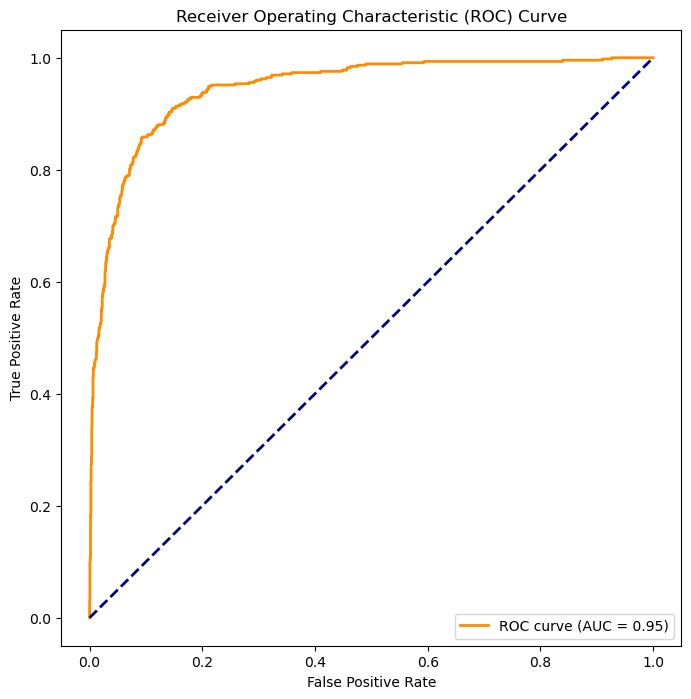

In [176]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Convert string labels to binary labels
le = LabelEncoder()
labels_test_binary = le.fit_transform(labels_test)
y_pred_binary = le.transform(y_pred)

# Confusion Matrix
cm = confusion_matrix(labels_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(labels_test_binary, best_svm_model.decision_function(X_test_tfidf))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [107]:
# Testing some tweets pulled from my friend's twitter @7weekslive

# https://twitter.com/lithub/status/1729252483594342681

# https://twitter.com/JhariahClare/status/1730093772220879058

# https://twitter.com/RamiJarrah/status/1729611779787964717

# https://twitter.com/sitcomabed/status/1730753622684623083

# https://twitter.com/muttnik/status/1731119902575178202

# From the tweets above
test_sentences = ["Gaza’s main public library has been destroyed.",
                  "Palestine is still persevering. They will be free. Do not let them do it alone please.",
                   "Bernie Sanders is now the lone senator from Vermont, NOT calling for a ceasefire.",
                   "im feeling really grateful for every club on my campus that has been using their time to help fight for Palestinians.  A lot of those clubs are mostly comprised of poc and it just solidifies the solidarity between us. Our president is so horrible so its nice to have their support.",
                   "Rain or shine SF shows up for Palestine",
                   "The 49ers are winning the super bowl this year."]

# This was the model stored from the best performing accuracy test using SVM. We did this one with no neutral reviews and greater than 70% confidence
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# prepocessing using function from above
cleaned_test_sentences = [tweet_to_words(sentence) for sentence in test_sentences]

X_test_sentences_tfidf = vectorizer.transform(cleaned_test_sentences)

predictions = best_svm_model.predict(X_test_sentences_tfidf)

# Printing
for sentence, prediction in zip(test_sentences, predictions):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {prediction}")
    print("------")


Sentence: Gaza’s main public library has been destroyed.
Predicted Sentiment: negative
------
Sentence: Palestine is still persevering. They will be free. Do not let them do it alone please.
Predicted Sentiment: negative
------
Sentence: Bernie Sanders is now the lone senator from Vermont, NOT calling for a ceasefire.
Predicted Sentiment: negative
------
Sentence: im feeling really grateful for every club on my campus that has been using their time to help fight for Palestinians.  A lot of those clubs are mostly comprised of poc and it just solidifies the solidarity between us. Our president is so horrible so its nice to have their support.
Predicted Sentiment: negative
------
Sentence: Rain or shine SF shows up for Palestine
Predicted Sentiment: negative
------
Sentence: The 49ers are winning the super bowl this year.
Predicted Sentiment: negative
------


In [186]:
app = Twitter("session")

all_tweets = app.get_tweets("StephenCurry30")
for tweet in all_tweets:
    print(tweet)

Tweet(id=1537677040597483525, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2022-06-17 06:02:29+00:00)
Tweet(id=1538964823311908864, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2022-06-20 19:19:41+00:00)
Tweet(id=1575513553368293376, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2022-09-29 15:51:17+00:00)
Tweet(id=1425243515307450372, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2021-08-10 23:51:48+00:00)
Tweet(id=1529256335635890176, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2022-05-25 00:21:37+00:00)
Tweet(id=1025808660637745152, author=User(id=42562446, username=StephenCurry30, name=Stephen Curry, verified=True), created_on=2018-08-04 18:20:17+00:00)
Tweet(id=1623185534301655040, author=User(id=42562446, username=StephenCurry

In [39]:
all_tweets

UserTweets(user_id=42562446, count=0)

In [61]:
# Tokenize and count the words using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets_noneg['cleaned_text'])
word_counts = X.sum(axis=0)

# Convert word counts to a DataFrame
word_counts_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': word_counts.tolist()[0]})

# Sort the DataFrame by count in descending order
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Select the top 10 words
top_10_words = word_counts_df.head(10)

# Create a bar plot using Plotly
fig = px.bar(
    top_10_words,
    x='count',
    y='word',
    orientation='h',
    title='Top 10 Words Count',
    labels={'count': 'Count', 'word': 'Word'},
    template='plotly_dark'
)

fig.show()

In [179]:
tweets_noneg['length'] = tweets_noneg.text.str.split().apply(len)

# Create histogram using Plotly Express
histogram = px.histogram(
    tweets_noneg[tweets_noneg['airline_sentiment'] == 'negative'],
    x='length',
    nbins=20,
    labels={'length': 'Text Length'},
    color_discrete_sequence=['red'],
)

# Add histogram trace with outlined bins
histogram.update_traces(
    marker_line_width=1.5,
    marker_line_color='white',
    opacity=0.7,
)

# Create descriptive statistics table
describe = tweets_noneg.length[tweets_noneg.airline_sentiment == 'negative'].describe().to_frame().round(2)
table = go.Figure(data=[go.Table(
    header=dict(values=['Statistic', 'Value']),
    cells=dict(values=[describe.index, describe['length']]),
)])

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Distribution of Text Length', 'Descriptive Statistics'],
    column_widths=[0.7, 0.3],
    specs=[[{'type': 'xy'}, {'type': 'table'}]]
)

# Add histogram to subplot
for trace in histogram.data:
    fig.add_trace(trace, row=1, col=1)

# Add table to subplot
for trace in table.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout for subplot-like appearance
fig.update_layout(
    title='Distribution of Tweet Length and Descriptive Statistics for Negative Sentiment Tweets',
    template='plotly_dark'
)   

# Add explicit x-axis and y-axis labels
fig.update_xaxes(title_text='Length of Tweet by Word Count', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.show()


***

# **EDA Plots**

***

In [238]:
# Negative Sentiment Text Length

color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

unique_airlines = tweets_noneg['airline'].unique()

neg_only = tweets_noneg[tweets_noneg['airline_sentiment'] == 'negative']

neg_only['length_stopwords'] = tweets_noneg.cleaned_text_stopwords.str.split().apply(len)

# Create subplots for each airline
fig = make_subplots(
    rows=len(unique_airlines) // 3 + 1, cols=3,
    subplot_titles=unique_airlines,
    column_widths=[0.15, 0.15, 0.15],
    row_heights=[0.4] * (len(unique_airlines) // 3) + [0.15],
    specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}] for _ in range(len(unique_airlines) // 3 + 1)]
)

# Create histograms for each airline
for i, airline in enumerate(unique_airlines):
    subset = neg_only[neg_only['airline'] == airline]

    histogram = go.Histogram(
        x=subset['length_stopwords'],
        nbinsx=20,
        marker=dict(color=color_discrete_map.get(airline, 'gray'), line=dict(color='white', width=1.5)),
        opacity=0.7,
        name=airline
    )

    # Add histogram to subplot
    fig.add_trace(histogram, row=i // 3 + 1, col=i % 3 + 1)

    # Add explicit x-axis and y-axis labels
    fig.update_xaxes(title_text='Text Length', row=i // 3 + 1, col=i % 3 + 1)
    fig.update_yaxes(title_text='Frequency', row=i // 3 + 1, col=i % 3 + 1)

# Update layout for subplot-like appearance
fig.update_layout(
    title='Distribution of Negative Sentiment Tweet Length (by Words) for Each Airline',
    template='plotly_white',
    height=800,
    margin=dict(l=20, r=20, b=50, t=80),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Update title font size
fig.update_layout(
    title_font=dict(size=18),
    title_font_family="Calibri",
)

# Update subplot title font size
fig.update_annotations(font=dict(size=12))

fig.show()


In [240]:
# Positive Sentiment Text Length

color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

unique_airlines = tweets_noneg['airline'].unique()

pos_only = tweets_noneg[tweets_noneg['airline_sentiment'] == 'positive']

pos_only['length_stopwords'] = tweets_noneg.cleaned_text_stopwords.str.split().apply(len)

# Create subplots for each airline
fig = make_subplots(
    rows=len(unique_airlines) // 3 + 1, cols=3,
    subplot_titles=unique_airlines,
    column_widths=[0.15, 0.15, 0.15],
    row_heights=[0.4] * (len(unique_airlines) // 3) + [0.15],
    specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}] for _ in range(len(unique_airlines) // 3 + 1)]
)

# Create histograms for each airline
for i, airline in enumerate(unique_airlines):
    subset = pos_only[pos_only['airline'] == airline]

    histogram = go.Histogram(
        x=subset['length_stopwords'],
        nbinsx=20,
        marker=dict(color=color_discrete_map.get(airline, 'gray'), line=dict(color='white', width=1.5)),
        opacity=0.7,
        name=airline
    )

    # Add histogram to subplot
    fig.add_trace(histogram, row=i // 3 + 1, col=i % 3 + 1)

    # Add explicit x-axis and y-axis labels
    fig.update_xaxes(title_text='Text Length', row=i // 3 + 1, col=i % 3 + 1)
    fig.update_yaxes(title_text='Frequency', row=i // 3 + 1, col=i % 3 + 1)

# Update layout for subplot-like appearance
fig.update_layout(
    title='Distribution of Positive Sentiment Tweet Length (by Words) for Each Airline',
    template='plotly_white',
    height=800,
    margin=dict(l=20, r=20, b=50, t=80),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Update title font size
fig.update_layout(
    title_font=dict(size=18),
    title_font_family="Calibri",
)

# Update subplot title font size
fig.update_annotations(font=dict(size=12))

fig.show()

In [146]:
from scipy.stats import ttest_ind

# Assuming you have a DataFrame named 'data_clean' with columns 'cleaned_text' and 'airline_sentiment'

# Perform a t-test for independent samples
t_statistic, p_value = ttest_ind(neg_only['length'], pos_only['length'], equal_var=False)

# Print the results
print(f'T-Statistic: {t_statistic:.4f}')
print(f'P-Value: {p_value:.4f}')

# Check for significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in text length between negative and positive responses.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in text length between negative and positive responses.")


T-Statistic: 36.0097
P-Value: 0.0000
Reject the null hypothesis: There is a significant difference in text length between negative and positive responses.


In [270]:
from scipy.stats import kruskal

# Assuming 'data_clean' is your DataFrame with the 'cleaned_text' and 'airline' columns

tweets['length_stopwords'] = tweets.cleaned_text_stopwords.str.split().apply(len)

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*[tweets['length_stopwords'] for name, group in tweets_noneg.groupby('airline')])

# Print the results
print(f'Kruskal-Wallis H-statistic: {statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Check for significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in text length between different airlines.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.")


Kruskal-Wallis H-statistic: 0.0000
P-value: 1.0000
Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.


In [271]:
# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*[pos_only['length_stopwords'] for name, group in pos_only.groupby('airline')])

# Print the results
print(f'Kruskal-Wallis H-statistic: {statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Check for significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in text length between different airlines.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.")

Kruskal-Wallis H-statistic: 0.0000
P-value: 1.0000
Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.


In [272]:
# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*[neg_only['length_stopwords'] for name, group in neg_only.groupby('airline')])

# Print the results
print(f'Kruskal-Wallis H-statistic: {statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Check for significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in text length between different airlines.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.")

Kruskal-Wallis H-statistic: 0.0000
P-value: 1.0000
Fail to reject the null hypothesis: There is no significant difference in text length between different airlines.


In [277]:
# Calculate tweet lengths
negative_lengths = neg_only['length_stopwords'].mean()
positive_lengths = pos_only['length_stopwords'].mean()

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(positive_lengths, negative_lengths)

# Display the results
print("Kruskal-Wallis Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in tweet lengths.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in tweet lengths.")

Kruskal-Wallis Statistic: 1.0
P-value: 0.31731050786291115
Fail to reject the null hypothesis. There is no significant difference in tweet lengths.


In [280]:
print(positive_lengths)
print(negative_lengths)

13.925536574682436
19.509797446059004


In [183]:
pos_only["length"].mean()
neg_only["length"].mean()


19.686206145129656